# Centroid mapping for cell type identification

Jupyter notebook containing code to identify cell types using a revised method for Frederico Scala and Dmitry Kobak (https://www.nature.com/articles/s41586-020-2907-3). Analyses correspond to !!!!!!

This notebook contains code that calls cell types for each cell in a query dataset based on correlation to a pre-clustered reference dataset. For each cluster in the annotated reference dataset, a centroid cell is generated by calculating the average value of all variable genes used to generate the clusters. Correlation coefficients for each query cell's gene expression profile are then calculated against each centroid. Cells are mapped to the centroid type with the highest correlation coefficient.

To calculate embeddings for visualization, correlation coefficients are again calculated for all variable genes for each query cell and reference annotated cell. Coordinates are assigned by taking the X and Y medians of the top N nearest neighbors for said query cell.

Input for this analysis includes:
1. A sparse gene expression matrix for the reference dataset
2. The list of variable genes used to cluster the reference dataset
3. A metadata file containing cell type annotations to be used for each reference cell
4. A sparse gene expression matrix for the query dataset

Output for this analysis incudes:
1. A dataframe with correlation coefficient scores for each cell x centroid comparison
2. A pooled dataframe with filtered cell type assignments for each query dataset
3. Violin plots showing distribution of maximum correlation coefficient scores for each dataset
4. Dataframes split by dataset with visualization coordinates for each query cell

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: !!!!!!

This code was last amended by Maddie Urbanek on !!!!!

## Notebook set-up

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
import os
import time
#from multiprocessing import Pool
import multiprocess as mp
pd.options.mode.chained_assignment = None
import scanpy as sc
import anndata as ad

In [1]:
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/transcriptome/')

## Import reference data

The sparse matrices for each dataset used here are coming directly from the R markdown file ##_transcriptome_qc_double_filtering.rmd. This means that they should have already been filtered based on number of features, unique genes, mitochondrial content, and singlet status.

Reference variable genes and metadata are also pulled using the R markdown file. For Shin & Urbanek, the reference atlas is from https://www.nature.com/articles/s41586-024-08351-7. All datasets mapping to second trimester were subset and used for this analysis.

##### Reference data

In [ ]:
#Load in reference variable genes
ref_variable_genes=pd.read_table('./ref_var_genes.csv',delimiter=',')

#Load in reference metadata
ref_metadata= pd.read_table('./ref_metadata.csv',delimiter=',')

#Load in reference sparse matrix
ref_data = pd.read_table('./ref_ref.csv',delimiter=',',index_col=0)

## Build functions for calculating correlation coefficients

In [ ]:
#Build corr2 (Pearson correlation coefficient) matlab function
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

## Centroid mapping

### Build function for mapping to clusters

The following command has the copacity to subset down to a shared list of variable genes between the reference and query dataset, but for Shin & Urbanek, the top 3000 variable genes used to cluster the reference dataset were used.

In [ ]:
def centroid_mapping(referenceCounts, #sparse reference matrix
                             referenceGenes, #reference variable gene list
                             newCounts, #sparse sample matrix
                             newGenes, #sample variable gene list
                             referenceClusters, #reference metadata column with cell type annotations
                             normSeqDepth=True, #normalizes matrices by dividing by total counts per cell, multiplying by a scale factor, then taking the log of that value + 1 
                             scaleFactor=10000, #scale factor for normalization, scanpy and Seurat use 10,000
                             returnCmeans = False, #whether to return matrix of correlation values for each cell x centroid combo
                             totalClusters = None, #if you want to specify a different number of unique clusters
                             writeAssignmentDataframe = [], #where to save cell type assignment dataframe to on local machine
                             writeCorrScoresDataframe = []): #where to save correlation coefficient matrix on local machine

    starttime = time.time()
    print(starttime)

    if normSeqDepth:
        #Genes counts for each cell are divided by the total UMIs for that cell, then multiplied by a scale factor. 
        print('Normalizing sample matrix to sequencing depth per cell')
        newCounts.loc['total_counts'] = newCounts.sum(numeric_only=True, axis=0)
        normalized = newCounts.divide(newCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor
        #This is then natural-log transformed using log1p
        X=np.log1p(normalized)
    else:
        #Or process with just the raw matrix with log1p scaling
        print('No sequencing depth normalization')
        X = np.log1p(X)
    
    #Repeat the same normalization steps as above, but for reference dataset
    if normSeqDepth:
        print('Normalizing reference matrix to sequencing depth per cell')
        referenceCounts.loc['total_counts'] = referenceCounts.sum(numeric_only=True, axis=0)
        normalized = referenceCounts.divide(referenceCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor         
        T=np.log1p(normalized)
    else:
        print('No sequencing depth normalization')
        T = np.log1p(T)

    #Save the normalized copies of the matrices
    norm_ref=T.copy(deep=True)
    norm_sample=X.copy(deep=True)

    #Identify overlapping genes between reference dataset and query dataset
    gg = sorted(list(set(referenceGenes) & set(newGenes)))

    #Report back how many genes are in common+being used for query mapping
    print('Using a common set of ' + str(len(gg)) + ' genes.')
    print()
    
    #For both datasets, pull all rows corresponding to variable features
    T = T.loc[gg]
    X = X.loc[gg]

    #If clusters are already specified, set K to that number
    if totalClusters is not None:
        K = totalClusters
    #Otherwise, manually calculate the number of total clusters by adding 1 to total number of reference clusters
    else:
        types=referenceClusters.unique()
        types=pd.DataFrame(types)
        types.columns=['type_assignment']
        types['cluster_number'] = types.index
        #Make dictionary to convert to integer cluster labels
        cell_type_dict = dict(zip(types['type_assignment'],types['cluster_number']))
        numerical_clusters = referenceClusters.replace(cell_type_dict)
        K = np.max(numerical_clusters) + 1

    #Assign clusters to cells in reference atlas
    T.columns=(ref_metadata['type_updated'])
    clusters = ref_metadata['type_updated'].unique()

    #Build centroids table by calculating the mean for each variable gene for all cells within a cluster
    centroids = pd.DataFrame(index=T.index)
    for celltype in clusters:
        corresponding_cells = T[celltype]
        means=corresponding_cells.mean(axis=1)
        means=pd.DataFrame(means)
        means.columns=[celltype]
        centroids = pd.concat([centroids, means], axis=1) 

    #For each cell, calculate correlation coefficient across all variable genes for each centroid
    #print(centroids)
    input_cells=X.columns
    Cmeans=[]
    for sample_cell in input_cells:
        individual_Cmeans=[sample_cell]
        for celltype in clusters:
            calculated=corr2(X[sample_cell], centroids[celltype])
            individual_Cmeans.append(calculated)
        Cmeans.append(individual_Cmeans)
    corr_scores = pd.DataFrame(Cmeans)
    corr_scores=corr_scores.set_index(0)
    corr_scores.columns=clusters

    #Assign clusters based on highest value concordance (excluding any NaNs)
    type_assignment = corr_scores.idxmax(axis=1)

    #Save cluster assignments and correlation coefficients to local machine
    type_assignment.to_csv(writeAssignmentDataframe)
    corr_scores.to_csv(writeCorrScoresDataframe)
    
    print('Done assigning cell types! :)')
    print()
    print('This took...')
    endtime = time.time()
    print(endtime-starttime)
    print('seconds!')

    #Return normalized matrices and type assignments
    if returnCmeans:
        return type_assignment, corr_scores, norm_ref, norm_sample 
    else:
        return type_assignment, norm_ref, norm_sample


### Run centroid_mapping() function on each query dataset

In [ ]:
#S1
sample_data=pd.read_table('./filtered_sparse_matrices/s1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s1_cluster_assignments, s1_centroid_means, norm_ref, norm_s1 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/s1_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/s1_corr_scores.csv')


#S2
sample_data=pd.read_table('./filtered_sparse_matrices/s2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s2_cluster_assignments, s2_centroid_means, norm_ref, norm_s2 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/s2_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/s2_corr_scores.csv')

#S3
sample_data=pd.read_table('./filtered_sparse_matrices/s3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s3_cluster_assignments, s3_centroid_means, norm_ref, norm_s3 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/s3_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/s3_corr_scores.csv')


#S4
sample_data=pd.read_table('./filtered_sparse_matrices/s4_sparse.csv',delimiter=',',index_col=0)
sbset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s4_cluster_assignments, s4_centroid_means, norm_ref, norm_s4 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/s4_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/s4_corr_scores.csv')

#S5
sample_data=pd.read_table('./filtered_sparse_matrices/s5_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s5_cluster_assignments, s5_centroid_means, norm_ref, norm_s5 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/s5_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/s5_corr_scores.csv')

#C1
sample_data=pd.read_table('./filtered_sparse_matrices/c1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c1_cluster_assignments, c1_centroid_means, norm_ref, norm_c1 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/c1_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/c1_corr_scores.csv')


#C2
sample_data=pd.read_table('./filtered_sparse_matrices/c2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c2_cluster_assignments, c2_centroid_means, norm_ref, norm_c2 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/c2_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/c2_corr_scores.csv')

#C3
sample_data=pd.read_table('./filtered_sparse_matrices/c3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c3_cluster_assignments, c3_centroid_means, norm_ref, norm_c3 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/c3_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/c3_corr_scores.csv')

#C4
sample_data=pd.read_table('./filtered_sparse_matrices/c4_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c4_cluster_assignments, c4_centroid_means, norm_ref, norm_c4 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/c4_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/c4_corr_scores.csv')

#N1
sample_data=pd.read_table('./filtered_sparse_matrices/n1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n1_cluster_assignments, n1_centroid_means, norm_ref, norm_n1 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/n1_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/n1_corr_scores.csv')

#N2
sample_data=pd.read_table('./filtered_sparse_matrices/n2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n2_cluster_assignments, n2_centroid_means, norm_ref, norm_n2 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/n2_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/n2_corr_scores.csv')


#N3
sample_data=pd.read_table('./filtered_sparse_matrices/n3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n3_cluster_assignments, n3_centroid_means, norm_ref, norm_n3 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/n3_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/n3_corr_scores.csv')

#N4
sample_data=pd.read_table('./filtered_sparse_matrices/n4_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n4_cluster_assignments, n4_centroid_means, norm_ref, norm_n4 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/n4_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/n4_corr_scores.csv')

#U1
sample_data=pd.read_table('./filtered_sparse_matrices/u1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
u1_cluster_assignments, u1_centroid_means, norm_ref, norm_u1 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/u1_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/u1_corr_scores.csv')


#U2
sample_data=pd.read_table('./filtered_sparse_matrices/u2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
u2_cluster_assignments, u2_centroid_means, norm_ref, norm_u2 = centroid_mapping(ref_data, 
                                                                                        subset_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        subset_variable_genes['x'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./centroid_assignments/u2_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./corr_scores/u2_corr_scores.csv')

### Get correlation coefficient for highest centroid per cell

If needed, the following cell can be used to reload data

In [8]:
s1_centroid_means=pd.read_table('./corr_scores/s1_corr_scores.csv',delimiter=',',index_col='0')
s2_centroid_means=pd.read_table('./corr_scores/s2_corr_scores.csv',delimiter=',',index_col='0')
s3_centroid_means=pd.read_table('./corr_scores/s3_corr_scores.csv',delimiter=',',index_col='0')
s4_centroid_means=pd.read_table('./corr_scores/s4_corr_scores.csv',delimiter=',',index_col='0')
s5_centroid_means=pd.read_table('./corr_scores/s5_corr_scores.csv',delimiter=',',index_col='0')

c1_centroid_means=pd.read_table('./corr_scores/c1_corr_scores.csv',delimiter=',',index_col='0')
c2_centroid_means=pd.read_table('./corr_scores/c2_corr_scores.csv',delimiter=',',index_col='0')
c3_centroid_means=pd.read_table('./corr_scores/c3_corr_scores.csv',delimiter=',',index_col='0')
c4_centroid_means=pd.read_table('./corr_scores/c4_corr_scores.csv',delimiter=',',index_col='0')

n1_centroid_means=pd.read_table('./corr_scores/n1_corr_scores.csv',delimiter=',',index_col='0')
n2_centroid_means=pd.read_table('./corr_scores/n2_corr_scores.csv',delimiter=',',index_col='0')
n3_centroid_means=pd.read_table('./corr_scores/n3_corr_scores.csv',delimiter=',',index_col='0')
n4_centroid_means=pd.read_table('./corr_scores/n4_corr_scores.csv',delimiter=',',index_col='0')

u1_centroid_means=pd.read_table('./corr_scores/u1_corr_scores.csv',delimiter=',',index_col='0')
u2_centroid_means=pd.read_table('./corr_scores/u2_corr_scores.csv',delimiter=',',index_col='0')

In [9]:
dataset_list=[s1_centroid_means,
              s2_centroid_means,
              s3_centroid_means,
              s4_centroid_means,
              s5_centroid_means,
              c1_centroid_means,
              c2_centroid_means,
              c3_centroid_means,
              c4_centroid_means,
              n1_centroid_means,
              n2_centroid_means,
              n3_centroid_means,
              n4_centroid_means,
              u1_centroid_means,
              u2_centroid_means
             ]

for i in dataset_list:
    i['high_score'] = i.max(axis=1)

### Plot distribution of maximum correlation coefficients for each dataset

In [10]:
#Pooling plots by viral strain and dissociation modality
def plot_pooled_corr(dataset_list, dataset_palette):
    high_scores=pd.DataFrame()
    for i in dataset_list:
        high_score=i['high_score']
        high_score = pd.DataFrame(high_score)       
        high_scores=pd.concat((high_score,high_scores))
    high_scores['cellbarcode']=high_scores.index
    high_scores[['dataset_id','cbc']]=high_scores['cellbarcode'].str.split('_', expand=True)
    high_scores.loc[high_scores['dataset_id'].isin(['s1','s2','s3','s4','s5']), 'cbc'] = 'SADB-19, cell'
    high_scores.loc[high_scores['dataset_id'].isin(['c1','c2','c3','c4']), 'cbc'] = 'CVS-N2c, cell'
    high_scores.loc[high_scores['dataset_id'].isin(['n1','n2','n3','n4']), 'cbc'] = 'CVS-N2c, nuc'
    high_scores.loc[high_scores['dataset_id'].isin(['u1']), 'cbc'] = 'Uninfected, cell'
    high_scores.loc[high_scores['dataset_id'].isin(['u2']), 'cbc'] = 'Uninfected, nuc'
    
    #No palette specified
    #sns.violinplot(x='dataset_id', y='high_score', data=high_scores)
    
    #With palette specified above
    fig, ax = plt.subplots(figsize=(5, 5))
    
    sns.violinplot(x='dataset_id', y='high_score', 
                   data=high_scores, 
                   hue = 'dataset_id',
                   palette=dataset_palette,
                   legend=False,
                   alpha=0.5)
    
    return high_scores

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_45249/2929117133.py:22: UserWarning: 
The palette list has fewer values (2) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='dataset_id', y='high_score',


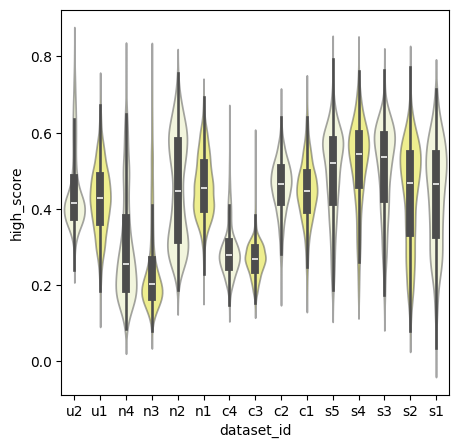

In [12]:
pooled_coor=plot_pooled_corr(dataset_list, dataset_palette)

### Threshold annotations based on maximum correlation coefficient

If needed, the following cell can be used to reload annotations

In [18]:
s1_assignment=pd.read_table('./centroid_assignments/s1_centroid_assignment.csv',delimiter=',')
s1_assignment.columns=['cellbarcode','celltype']
s1_assignment['datasetid']='s1'

s2_assignment=pd.read_table('./centroid_assignments/s2_centroid_assignment.csv',delimiter=',')
s2_assignment.columns=['cellbarcode','celltype']
s2_assignment['datasetid']='s2'

s3_assignment=pd.read_table('./centroid_assignments/s3_centroid_assignment.csv',delimiter=',')
s3_assignment.columns=['cellbarcode','celltype']
s3_assignment['datasetid']='s3'

s4_assignment=pd.read_table('./centroid_assignments/s4_centroid_assignment.csv',delimiter=',')
s4_assignment.columns=['cellbarcode','celltype']
s4_assignment['datasetid']='s4'

s5_assignment=pd.read_table('./centroid_assignments/s5_centroid_assignment.csv',delimiter=',')
s5_assignment.columns=['cellbarcode','celltype']
s5_assignment['datasetid']='s5'

c1_assignment=pd.read_table('./centroid_assignments/c1_centroid_assignment.csv',delimiter=',')
c1_assignment.columns=['cellbarcode','celltype']
c1_assignment['datasetid']='c1'

c2_assignment=pd.read_table('./centroid_assignments/c2_centroid_assignment.csv',delimiter=',')
c2_assignment.columns=['cellbarcode','celltype']
c2_assignment['datasetid']='c2'

c3_assignment=pd.read_table('./centroid_assignments/c3_centroid_assignment.csv',delimiter=',')
c3_assignment.columns=['cellbarcode','celltype']
c3_assignment['datasetid']='c3'

c4_assignment=pd.read_table('./centroid_assignments/c4_centroid_assignment.csv',delimiter=',')
c4_assignment.columns=['cellbarcode','celltype']
c4_assignment['datasetid']='c4'

n1_assignment=pd.read_table('./centroid_assignments/n1_centroid_assignment.csv',delimiter=',')
n1_assignment.columns=['cellbarcode','celltype']
n1_assignment['datasetid']='n1'

n2_assignment=pd.read_table('./centroid_assignments/n2_centroid_assignment.csv',delimiter=',')
n2_assignment.columns=['cellbarcode','celltype']
n2_assignment['datasetid']='n2'

n3_assignment=pd.read_table('./centroid_assignments/n3_centroid_assignment.csv',delimiter=',')
n3_assignment.columns=['cellbarcode','celltype']
n3_assignment['datasetid']='n3'

n4_assignment=pd.read_table('./centroid_assignments/n4_centroid_assignment.csv',delimiter=',')
n4_assignment.columns=['cellbarcode','celltype']
n4_assignment['datasetid']='n4'

u1_assignment=pd.read_table('./centroid_assignments/u1_centroid_assignment.csv',delimiter=',')
u1_assignment.columns=['cellbarcode','celltype']
u1_assignment['datasetid']='u1'

u2_assignment=pd.read_table('./centroid_assignments/u2_centroid_assignment.csv',delimiter=',')
u2_assignment.columns=['cellbarcode','celltype']
u2_assignment['datasetid']='u2'

For Shin & Urbanek, dropped any cell where the maximum correlation coefficient was <0.2

In [21]:
#Concatenate all the correlation coefficient matrices
centroid_means=pd.concat(dataset_list)
centroid_means

#Drop all rows where high_score is <0.2
filtered_centroid_means=centroid_means[~(centroid_means['high_score'] < 0.2)] 
filtered_centroid_means

#Print some stats about number of retained cells 
print('Number of cells pre-thresholding:')
print(len(centroid_means))
print()
print('Number of cells post-thesholding:')
print(len(filtered_centroid_means))
print()
print('Percentage of cells retained for analysis:')
print((len(filtered_centroid_means)/len(centroid_means)*100))

Number of cells pre-thresholding:
49554

Number of cells post-thesholding:
46672

Percentage of cells retained for analysis:
94.18412237155427


Subset the assignment dataframes to just those cells passing the filter, then concatenate into one large dataframe for exporting

In [22]:
s1_filtered_assignment = s1_assignment[s1_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
s2_filtered_assignment = s2_assignment[s2_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
s3_filtered_assignment = s3_assignment[s3_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
s4_filtered_assignment = s4_assignment[s4_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
s5_filtered_assignment = s5_assignment[s5_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

c1_filtered_assignment = c1_assignment[c1_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
c2_filtered_assignment = c2_assignment[c2_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

n1_filtered_assignment = n1_assignment[n1_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
n2_filtered_assignment = n2_assignment[n2_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

c3_filtered_assignment = c3_assignment[c3_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
c4_filtered_assignment = c4_assignment[c4_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

n3_filtered_assignment = n3_assignment[n3_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
n4_filtered_assignment = n4_assignment[n4_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

u1_filtered_assignment = u1_assignment[u1_assignment['cellbarcode'].isin(filtered_centroid_means.index)]
u2_filtered_assignment = u2_assignment[u2_assignment['cellbarcode'].isin(filtered_centroid_means.index)]

filtered_assignments = pd.concat([s1_filtered_assignment, 
                                  s2_filtered_assignment,
                                  s3_filtered_assignment,
                                  s4_filtered_assignment,
                                  s5_filtered_assignment,
                                  c1_filtered_assignment,
                                  c2_filtered_assignment,
                                  n1_filtered_assignment,
                                  n2_filtered_assignment,
                                  c3_filtered_assignment,
                                  c4_filtered_assignment,
                                  n3_filtered_assignment,
                                  n4_filtered_assignment,
                                  u1_filtered_assignment,
                                  u2_filtered_assignment
                                 ], 
                                 axis=0, 
                                 ignore_index=True)

filtered_assignments

,cellbarcode,celltype,datasetid
0,s1_AAAAAAGGCCTCATCA,EN-Newborn,s1
1,s1_AAAAAATGAGATAGTT,EN-Newborn,s1
2,s1_AAAAAGCGATTGAGCA,EN-Newborn,s1
3,s1_AAAAAGTGAGAGACGC,EN-Newborn,s1
4,s1_AAAACCAGAGGTATTA,IPC-EN,s1
...,...,...,...
46667,u2_CCTTCCGTCCCTAAAT,EN-L2_3-IT,u2
46668,u2_CCTTCCTACATACCAT,EN-L4-IT,u2
46669,u2_CCTTCCTCAACCAAAG,EN-L4-IT,u2
46670,u2_CCTTCCTCCCATACCA,RG-tRG,u2


Export thresholded cell annotations:

In [ ]:
filtered_assignments.to_csv('./filtered_assignments.csv')

## Calculate cell embeddings

### Build function for calculating visualization embeddings based on kNN

The following function can handle separate variable gene lists for each query dataset. For Shin & Urbanek, the reference variable genes were used for each. The gene lists used to call cell types via centroid mapping and calculate embeddings should be identical! Normalization methods should also be identical for both centroid mapping and embeding calculation. By default, the following function will normalize to sequencing depth per cell

In [25]:
def calculate_embeddings(referenceCounts, #reference matrix
                       referenceGenes, #reference variable genes list
                       newCounts, #query matrix
                       newGenes, #if using, query matrix gene list--otherwise, can be reference variable genes list subset to genes measured in query dataset
                       referenceAtlas, #coordinates representing the embeddings for each cell from the reference atlas
                       scaleFactor=10000, #normalization scale factor
                       selectMedian=True, #whether to calculate the median or a weighted average for the query embeddings
                       knn = 10, #number of neighbors to consider when selecting median/weighted mean
                         write_assignment_dataframe = [] #where to save assignment dataframe to on local machine
                        ):
    
    if __name__ == '__main__':    
    
        starttime = time.time()
        print(starttime)

        #Genes counts for each cell are divided by the total UMIs for that cell, then multiplied by a scale factor. 
        print('Normalizing sample matrix to sequencing depth per cell')
        newCounts.loc['total_counts'] = newCounts.sum(numeric_only=True, axis=0)
        normalized = newCounts.divide(newCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor
        #This is then natural-log transformed using log1p
        X=np.log1p(normalized)
    
        print('Normalizing reference matrix to sequencing depth per cell')
        referenceCounts.loc['total_counts'] = referenceCounts.sum(numeric_only=True, axis=0)
        normalized = referenceCounts.divide(referenceCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor         
        T=np.log1p(normalized)

    #Identify overlapping genes between reference dataset and query dataset (already did this in R)
        gg = sorted(list(set(referenceGenes) & set(newGenes)))

    #Report back how many genes are in common+being used for query mapping
        print('Using a common set of ' + str(len(gg)) + ' genes.')
        print()
    
    #For query dataset, pull all rows corresponding to variable features
    #If sparse matrix, send to dense
        T = referenceCounts.loc[gg]
        X = newCounts.loc[gg]

        ref_population=T.columns
        input_cells=X.columns
        assignmentPositions=pd.DataFrame()
        individual_assignment=[]
        print('Beginning correlation calculations')
        if selectMedian == True:
            print('Assigning coordinates based on median')

        if selectMedian==False:
            print('Assigning coordinates based on weighted means')
            
        global build_correlations
    
        def build_correlations(sample_cell):
            global build_correlations
            #global assignmentPositions
            print('.', end='', flush=True)
            individual_corr=[]
            for ref_cell in ref_population:
                calculated=corr2(X[sample_cell], T[ref_cell])
                individual_corr.append(calculated)
            ind = referenceAtlas[np.argpartition(individual_corr, -knn)][-knn:]
            
            if selectMedian == True:
                individual_assignment = np.median(ind,axis=0)

            if selectMedian == False:
                res = np.array(individual_corr)
                weights= res[np.argpartition(res, -knn)][-knn:]
                weights=np.transpose(weights)
                individual_assignment = np.average(ind,axis=0,weights=weights)
                
            temp = pd.DataFrame(individual_assignment)
            temp.columns=[sample_cell]
            return temp
    #
        pool = mp.Pool(32)  
        print('Calling workers')# Create a multiprocessing Pool
        assignmentPositions=pd.concat(pool.map(build_correlations, input_cells), axis=1)

    #Save output to local machine
        print(assignmentPositions)
        assignmentPositions=assignmentPositions.T
        assignmentPositions.to_csv(write_assignment_dataframe)

        print('Done finding UMAP coords! :)')
        print()
        print('This took...')
        endtime = time.time()
        print(endtime-starttime)
        print('seconds!')
        
        return assignmentPositions

### Run datasets through calculate_embeddings() function

In [ ]:
#Pull reference cell coords from ref_metadata file
ref_coords = ref_metadata[['umap_1','umap_2']].to_numpy()

In [ ]:
#S1
sample_data=pd.read_table('./filtered_sparse_matrices/s1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s1_pos = calculate_embeddings(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/s1_umap.csv')

#S2
sample_data=pd.read_table('./filtered_sparse_matrices/s2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s2_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/s2_umap.csv')

#S3
sample_data=pd.read_table('./filtered_sparse_matrices/s3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s3_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/s3_umap.csv')

#S4
sample_data=pd.read_table('./filtered_sparse_matrices/s4_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s4_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/s4_umap.csv')

#S5
sample_data=pd.read_table('./filtered_sparse_matrices/s5_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
s5_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/s5_umap.csv')

#C1
sample_data=pd.read_table('./filtered_sparse_matrices/c1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c1_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/c1_umap.csv')

#C2
sample_data=pd.read_table('./filtered_sparse_matrices/c2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c2_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/c2_umap.csv')

#C3
sample_data=pd.read_table('./filtered_sparse_matrices/c3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c3_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/c3_umap.csv')

#C4
sample_data=pd.read_table('./filtered_sparse_matrices/c4_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
c4_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/c4_umap.csv')

#N1
sample_data=pd.read_table('./filtered_sparse_matrices/n1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n1_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/n1_umap.csv')

#N2
sample_data=pd.read_table('./filtered_sparse_matrices/n2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n2_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/n2_umap.csv')

#N3
sample_data=pd.read_table('./filtered_sparse_matrices/n3_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n3_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/n3_umap.csv')

#N4
sample_data=pd.read_table('./filtered_sparse_matrices/n4_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
n4_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/n4_umap.csv')

#U1
sample_data=pd.read_table('./filtered_sparse_matrices/u1_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
u1_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/u1_umap.csv')

#U2
sample_data=pd.read_table('./filtered_sparse_matrices/u2_sparse.csv',delimiter=',',index_col=0)
subset_variable_genes=reference_variable_genes.loc[reference_variable_genes['x'].isin(sample_data.index)]
u2_pos = mod_mp_map_to_tsne(ref_data,subset_variable_genes['x'], 
                            sample_data, subset_variable_genes['x'], 
                            ref_coords, scaleFactor=10000, knn=10, selectMedian=True,
                            write_assignment_dataframe='./coordinates/u2_umap.csv')